In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

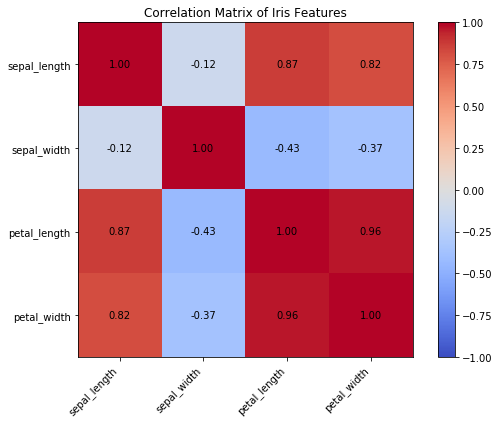

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# 1. 데이터 준비
iris = load_iris()
X = iris.data
y = iris.target

# 특성(X)과 타겟(y)을 함께 DataFrame으로 만들어 확인
df = pd.DataFrame(data=np.c_[X, y], columns=iris.feature_names + ['target'])
print("원본 데이터 클래스 비율:\n", df['target'].value_counts(normalize=True))

# 2. 데이터 분할 (기본)
# train_test_split 하이퍼파라미터
# *arrays: 분할할 배열들 (X, y 등)
# test_size: 테스트 세트의 비율 (0.0 ~ 1.0 사이의 float) 또는 개수 (int). (기본값=0.25)
# train_size: 훈련 세트의 비율 또는 개수. test_size와 둘 중 하나만 지정하는 것이 일반적.
# random_state: 재현성을 위한 시드 값.
# shuffle: 분할 전 데이터를 섞을지 여부. (기본값=True)
# stratify: 층화 샘플링을 위한 기준 배열 (보통 y를 지정). (기본값=None)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    shuffle=True
)

print("\n--- 기본 분할 후 클래스 비율 ---")
print("훈련 세트:\n", pd.Series(y_train).value_counts(normalize=True))
print("테스트 세트:\n", pd.Series(y_test).value_counts(normalize=True))
# 클래스 비율이 원본과 약간 다를 수 있음

# 3. 층화 샘플링을 사용한 데이터 분할
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    shuffle=True,
    stratify=y # y(타겟)의 클래스 비율을 유지하도록 지정
)

print("\n--- 층화 분할 후 클래스 비율 ---")
print("훈련 세트:\n", pd.Series(y_train_strat).value_counts(normalize=True))
print("테스트 세트:\n", pd.Series(y_test_strat).value_counts(normalize=True))
# 클래스 비율이 원본과 거의 동일하게 유지됨

print("\n--- 분할된 데이터 shape ---")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

원본 데이터 클래스 비율:
 2.0    0.333333
1.0    0.333333
0.0    0.333333
Name: target, dtype: float64

--- 기본 분할 후 클래스 비율 ---
훈련 세트:
 2    0.352381
1    0.352381
0    0.295238
dtype: float64
테스트 세트:
 0    0.422222
2    0.288889
1    0.288889
dtype: float64

--- 층화 분할 후 클래스 비율 ---
훈련 세트:
 2    0.333333
1    0.333333
0    0.333333
dtype: float64
테스트 세트:
 2    0.333333
1    0.333333
0    0.333333
dtype: float64

--- 분할된 데이터 shape ---
X_train shape: (105, 4)
X_test shape: (45, 4)
y_train shape: (105,)
y_test shape: (45,)


In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

iris = load_iris()
X = iris.data
y = iris.target
dt_clf = DecisionTreeClassifier(random_state=42)

In [4]:
# KFold 클래스 하이퍼파라미터
# n_splits: fold의 개수 (K). (기본값=5)
# shuffle: fold를 나누기 전 데이터를 섞을지 여부. (기본값=False)
# random_state: shuffle=True일 때 재현성을 위한 시드 값.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies_kfold = []
fold_idx = 1

# KFold 객체의 split() 메서드는 훈련/검증용 인덱스를 반환
for train_index, val_index in kfold.split(X):
    # 인덱스를 이용해 훈련/검증 데이터 분할
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # 모델 학습 및 예측
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_val)
    
    # 정확도 계산 및 저장
    accuracy = accuracy_score(y_val, pred)
    cv_accuracies_kfold.append(accuracy)
    print(f"K-Fold {fold_idx}차 검증 정확도: {accuracy:.3f}")
    fold_idx += 1

print(f"\nK-Fold 평균 검증 정확도: {np.mean(cv_accuracies_kfold):.3f}")

K-Fold 1차 검증 정확도: 1.000
K-Fold 2차 검증 정확도: 0.967
K-Fold 3차 검증 정확도: 0.933
K-Fold 4차 검증 정확도: 0.933
K-Fold 5차 검증 정확도: 0.933

K-Fold 평균 검증 정확도: 0.953


In [5]:
# StratifiedKFold는 split() 메서드에 X와 함께 y(타겟)를 반드시 전달해야 함
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies_skfold = []
fold_idx = 1

for train_index, val_index in skfold.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_val)
    
    accuracy = accuracy_score(y_val, pred)
    cv_accuracies_skfold.append(accuracy)
    print(f"Stratified K-Fold {fold_idx}차 검증 정확도: {accuracy:.3f}")
    fold_idx += 1

print(f"\nStratified K-Fold 평균 검증 정확도: {np.mean(cv_accuracies_skfold):.3f}")

Stratified K-Fold 1차 검증 정확도: 1.000
Stratified K-Fold 2차 검증 정확도: 0.967
Stratified K-Fold 3차 검증 정확도: 0.933
Stratified K-Fold 4차 검증 정확도: 0.967
Stratified K-Fold 5차 검증 정확도: 0.900

Stratified K-Fold 평균 검증 정확도: 0.953


In [6]:
# cross_val_score() 함수를 이용한 간편한 교차 검증
# cross_val_score(모델, 특성 데이터, 타겟 데이터, 평가 지표, 교차 검증 폴드 수)
# cv 인자에 KFold, StratifiedKFold 객체를 전달할 수도 있음
scores = cross_val_score(dt_clf, X, y, scoring='accuracy', cv=5)
print(f"\ncross_val_score()를 이용한 교차 검증 정확도: {scores}")
print(f"cross_val_score() 평균 정확도: {np.mean(scores):.3f}")

# 분류 문제에서는 cv에 정수만 입력해도 기본적으로 StratifiedKFold를 사용함
scores_strat = cross_val_score(dt_clf, X, y, scoring='accuracy', cv=skfold)
print(f"\ncross_val_score() (Stratified) 평균 정확도: {np.mean(scores_strat):.3f}")


cross_val_score()를 이용한 교차 검증 정확도: [0.96666667 0.96666667 0.9        0.93333333 1.        ]
cross_val_score() 평균 정확도: 0.953

cross_val_score() (Stratified) 평균 정확도: 0.953


--- 선형 회귀 모델 평가 ---
MSE: 0.556
RMSE: 0.746
R-squared (R²): 0.576

절편 (intercept): 2.0719469373788777
회귀 계수 (coefficients):
             Coefficient
MedInc         0.854383
AveBedrms      0.339259
HouseAge       0.122546
Population    -0.002308
AveOccup      -0.040829
AveRooms      -0.294410
Longitude     -0.869842
Latitude      -0.896929


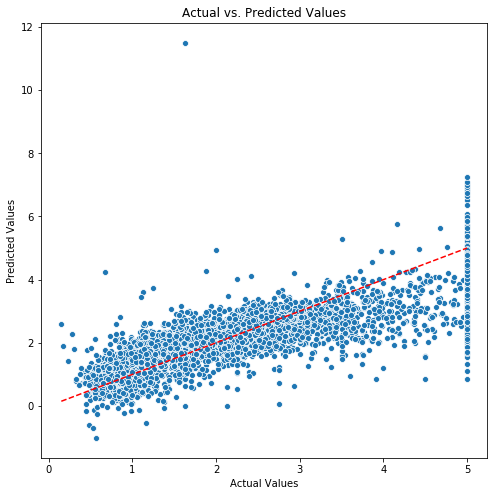

In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

# 2. 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. 모델 학습
# LinearRegression 하이퍼파라미터
# fit_intercept: 절편(bias)을 계산할지 여부. (기본값=True)
# normalize: 데이터를 정규화할지 여부. StandardScaler를 사용하는 것이 권장되므로 False로 둡니다. (Deprecated since version 1.0)
# n_jobs: 병렬 처리에 사용할 CPU 코어 수. -1이면 모든 코어 사용.
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 4. 예측 및 평가
y_pred = lin_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- 선형 회귀 모델 평가 ---")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

# 5. 학습된 계수 확인
print("\n절편 (intercept):", lin_reg.intercept_)
coef_df = pd.DataFrame(lin_reg.coef_, index=X.columns, columns=['Coefficient'])
print("회귀 계수 (coefficients):\n", coef_df.sort_values(by='Coefficient', ascending=False))

# 6. 결과 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # y=x 직선
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

# 1. 데이터 준비 및 전처리
housing = fetch_california_housing()
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. 릿지 회귀 (Ridge Regression)
# alpha: 규제 강도.
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
print(f"Ridge MSE: {mean_squared_error(y_test, ridge_pred):.3f}")

# 3. 라쏘 회귀 (Lasso Regression)
# alpha: 규제 강도.
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
print(f"Lasso MSE: {mean_squared_error(y_test, lasso_pred):.3f}")

# 라쏘의 특성 선택 효과 확인: 계수가 0이 된 변수들
lasso_coef = pd.Series(lasso.coef_, index=housing.feature_names)
print("\nLasso 회귀 계수 (0이 아닌 것):\n", lasso_coef[lasso_coef != 0].sort_values())

# 4. 엘라스틱넷 회귀 (ElasticNet Regression)
# alpha: 전체 규제 강도.
# l1_ratio: L1 규제의 비율 (0 <= l1_ratio <= 1). 0이면 L2(릿지), 1이면 L1(라쏘).
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
elastic_pred = elastic.predict(X_test_scaled)
print(f"\nElasticNet MSE: {mean_squared_error(y_test, elastic_pred):.3f}")

# 5. GridSearchCV를 이용한 최적 alpha 찾기 (Ridge 예시)
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(X_train_scaled, y_train)

print(f"\nGridSearchCV 최적 alpha (Ridge): {grid_ridge.best_params_['alpha']}")
print(f"최적 alpha 적용 시 MSE: {-grid_ridge.best_score_:.3f} (교차검증 평균)")

Ridge MSE: 0.556
Lasso MSE: 0.548

Lasso 회귀 계수 (0이 아닌 것):
 Latitude    -0.790113
Longitude   -0.755674
AveRooms    -0.162759
AveOccup    -0.030602
HouseAge     0.127087
AveBedrms    0.206207
MedInc       0.800957
dtype: float64

ElasticNet MSE: 0.636

GridSearchCV 최적 alpha (Ridge): 0.1
최적 alpha 적용 시 MSE: 0.519 (교차검증 평균)


Decision Tree MSE: 0.525
Random Forest MSE: 0.297

Feature Importances:
 MedInc        0.593833
AveOccup      0.139737
Latitude      0.076563
Longitude     0.076109
HouseAge      0.047918
AveRooms      0.031580
Population    0.017259
AveBedrms     0.017000
dtype: float64


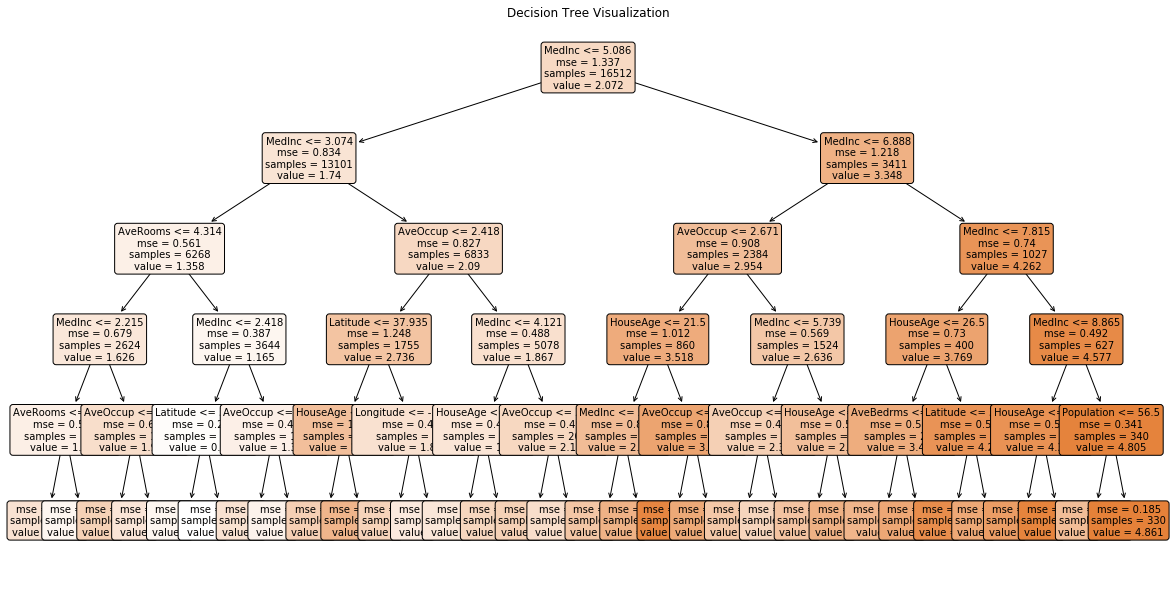

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. 데이터 준비
housing = fetch_california_housing()
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 결정 트리 회귀 (Decision Tree Regressor)
# 주요 하이퍼파라미터
# max_depth: 트리의 최대 깊이.
# min_samples_split: 노드를 분할하기 위한 최소 샘플 수.
# min_samples_leaf: 리프 노드가 되기 위한 최소 샘플 수.
dt_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)
print(f"Decision Tree MSE: {mean_squared_error(y_test, dt_pred):.3f}")

# 3. 랜덤 포레스트 회귀 (Random Forest Regressor)
# 주요 하이퍼파라미터
# n_estimators: 생성할 트리의 개수.
# max_features: 각 분할에서 고려할 최대 특성 수.
# n_jobs: 병렬 처리에 사용할 CPU 코어 수. -1이면 모두 사용.
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)
print(f"Random Forest MSE: {mean_squared_error(y_test, rf_pred):.3f}")

# 4. 특성 중요도 (Feature Importance) 확인
# 랜덤 포레스트는 각 특성이 모델의 예측에 얼마나 중요한지를 측정하는 feature_importances_ 속성을 제공
importances = pd.Series(rf_reg.feature_importances_, index=housing.feature_names)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))

# 5. 모델 시각화 (결정 트리)
plt.figure(figsize=(20, 10))
plot_tree(dt_reg, feature_names=housing.feature_names, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()